In [119]:
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
from sklearn.decomposition import PCA
import os 
from meshplot import plot, subplot 
import anndata as ad
import pandas as pd

In [120]:
import utils 
import spharm

In [154]:
timepoints = ['day1p5', 'day2', 'day2p5', 'day3', 'day3p5', 'day4', 'day4p5', 'day4p5-more']

zarr_names = {
    'day1p5': 'r0.zarr',
    'day2':'r0.zarr',
    'day2p5':'r0.zarr',
    'day3':'r0.zarr',
    'day3p5':'r0.zarr',
    'day4':'r0.zarr',
    'day4p5':'r0.zarr',
    'day4p5-more':'r0.zarr',
}


wells = {
    'day1p5': ['A01', 'A02', 'A03', 'A04', 'A06'],
    'day2': ['A01', 'A02', 'A03', 'A04', 'A05', 'A06'],
    'day2p5': ['A01', 'A02', 'A03', 'A04', 'A05', 'A06'],
    'day3': ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'B02', 'B03'],
    'day3p5': ['A01', 'A02', 'A03', 'A04', 'B03'],
    'day4': ['A02', 'A03', 'A04', 'A05', 'A06', 'B01', 'B02'],
    'day4p5': ['A06', 'B06'],
    'day4p5-more': ['C01', 'C02', 'C03', 'C04', 'C06'],
}

rounds = {
    'day1p5': ['0_fused'],
    'day2': ['0_fused'],
    'day2p5': ['0_fused'],
    'day3': ['0_fused'],
    'day3p5': ['0_fused'],
    'day4': ['0_fused'],
    'day4p5': ['0_fused'],
    'day4p5-more': ['0_fused'],
}

meshes = {
    'day1p5': ['nnorg_linked'],
    'day2': ['nnorg_linked'],
    'day2p5': ['nnorg_linked'],
    'day3': ['nnorg_linked'],
    'day3p5': ['nnorg_linked'],
    'day4': ['nnorg_linked'],
    'day4p5': ['nnorgb3'],
    'day4p5-more': ['nnorgb3'],
}

tables = {
    'day1p5':['mesh_features', 'nnorg_linked_expanded1_features'],
    'day2':['mesh_features', 'nnorg_linked_expanded1_features'],
    'day2p5':['mesh_features', 'nnorg_linked_expanded1_features'],
    'day3':['mesh_features', 'nnorg_linked_expanded1_features'],
    'day3p5':['mesh_features', 'nnorg_linked_expanded1_features'],
    'day4':['mesh_features', 'nnorg_linked_expanded1_features'],
    'day4p5':['mesh_features', 'nnorgb3_expanded_features'],
    'day4p5-more':['mesh_features', 'nnorgb3_expanded_features'],
}

times_dic = {
    '1p5': 1.5,
    '2': 2,
    '2p5': 2.5,
    '3': 3,
    '3p5': 3.5,
    '4': 4,
    '4p5': 4.5,
    '4p5-more': 4.5
}

In [122]:
def rerun_spharm(save_path): 
    m = spharm.SpHarm()
    m.load_results(save_path)  
    m.align_with_pca() 
    m.compute_initial_parameterization()
    m.optimize(max_outer_iterations=100, primal_steps=100, verbose=False)
    m.compute_sh_coefficients(lmax=15)
    m.save_results(save_path)

def load_spectrum(save_path):
    m = spharm.SpHarm()
    m.load_results(save_path)
    coor_spectrum = [] 
    for i in range(3): 
        sh = pysh.SHCoeffs.from_array(m.clms[i])
        coor_spectrum.append(sh.spectrum()) 
    return np.array(coor_spectrum)

def plot_explained_variance(pca):

    # Plot explained variance
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot explained variance ratio
    ax1.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Explained Variance Ratio by Component')
    ax1.grid(True, alpha=0.3)

    # Plot cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    ax2.plot(range(0, len(cumulative_variance) + 1), np.concatenate(([0], cumulative_variance,)), 'ko-')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% variance')
    ax2.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% variance')
    ax2.set_ylim([0, 1])
    ax2.set_xlim([0, 10])
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Total explained variance with {len(pca.explained_variance_ratio_)} components: {cumulative_variance[-1]:.4f}")
    print(f"Variance explained by first component: {pca.explained_variance_ratio_[0]:.4f}")
    print(f"Variance explained by second component: {pca.explained_variance_ratio_[1]:.4f}")

In [184]:
spectrums = [] 
clms = [] 
times = [] 
label_uids = []

for timepoint in timepoints:
    zarr_name = zarr_names[timepoint]
    for well_name in wells[timepoint]:
        round_name = rounds[timepoint][0]
        path = f"Data/fractal_output/{timepoint}/{zarr_name}/{well_name[0]}/{well_name[1:]}/{round_name}/"
        labels = np.load(path + 'good_labels.npy').astype('int')
        mesh_name = meshes[timepoint][0]
        mesh_table_name = tables[timepoint][0] 
        for label in labels:
            save_path = f"Data/fractal_output/{timepoint}/{zarr_name}/{well_name[0]}/{well_name[1:]}/{round_name}/meshes/{mesh_name}/{label}"

            mesh_table_path = f"Data/fractal_output/{timepoint}/{zarr_name}/{well_name[0]}/{well_name[1:]}/{round_name}/tables/{mesh_table_name}"

            if os.path.exists(save_path + '_clms.npy'):
                coor_spectrum = load_spectrum(save_path)
                if np.max(coor_spectrum) > 1 or np.isnan(coor_spectrum).any():
                    # rerun_spharm(save_path)
                    # coor_spectrum = load_spectrum(save_path)
                    print(save_path, np.max(coor_spectrum))
                else: 
                    spectrums.append(coor_spectrum)
                    clms.append(np.load(save_path + '_clms.npy'))
                    mesh_table = adata = ad.read_zarr(mesh_table_path).to_df() 
                    times.append(timepoint[3:])
                    label_uid = f'{timepoint}_{round_name}_{well_name}_{label}'
                    label_uids.append(label_uid)

Data/fractal_output/day1p5/r0.zarr/A/03/0_fused/meshes/nnorg_linked/61 nan
Data/fractal_output/day2/r0.zarr/A/01/0_fused/meshes/nnorg_linked/79 nan
Data/fractal_output/day3/r0.zarr/A/01/0_fused/meshes/nnorg_linked/134 nan
Data/fractal_output/day3/r0.zarr/A/04/0_fused/meshes/nnorg_linked/62 4.2722882211927264e+17
Data/fractal_output/day3/r0.zarr/A/04/0_fused/meshes/nnorg_linked/87 1.115790946684943
Data/fractal_output/day4p5/r0.zarr/A/06/0_fused/meshes/nnorgb3/44 nan
Data/fractal_output/day4p5/r0.zarr/B/06/0_fused/meshes/nnorgb3/52 nan
Data/fractal_output/day4p5-more/r0.zarr/C/01/0_fused/meshes/nnorgb3/5 nan
Data/fractal_output/day4p5-more/r0.zarr/C/01/0_fused/meshes/nnorgb3/74 nan
Data/fractal_output/day4p5-more/r0.zarr/C/02/0_fused/meshes/nnorgb3/28 nan
Data/fractal_output/day4p5-more/r0.zarr/C/02/0_fused/meshes/nnorgb3/67 nan
Data/fractal_output/day4p5-more/r0.zarr/C/02/0_fused/meshes/nnorgb3/84 nan
Data/fractal_output/day4p5-more/r0.zarr/C/02/0_fused/meshes/nnorgb3/138 nan
Data/frac

In [185]:
times_number = [times_dic[time] for time in times]
times_number = np.array(times_number)

(1635, 3, 16)


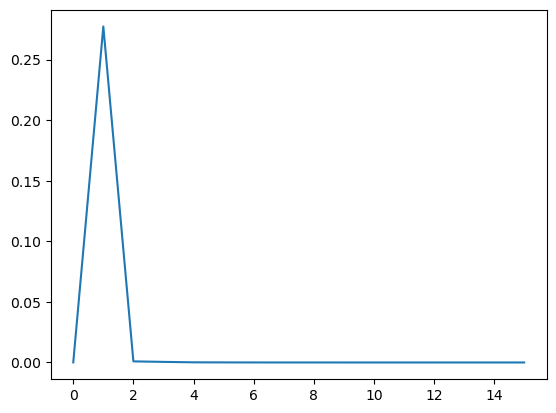

In [186]:
spectrums = np.array(spectrums)
print(spectrums.shape) 
medians = np.median(spectrums, axis=(0, 1))
plt.plot(medians) 
plt.show() 


In [187]:
spectrum_reshaped = spectrums.reshape(spectrums.shape[0], -1)
pca = PCA(n_components=10)
res = pca.fit(spectrum_reshaped) 

spectrum_pcs = pca.transform(spectrum_reshaped)
print(pca.components_.shape) 

(10, 48)


In [193]:
# Create the DataFrame
df_pca = pd.DataFrame({
    'label_uid': label_uids,
    'pca_coefficients': list(spectrum_pcs)
})
df_pca.to_csv('Data/pca_results.csv', index=False)

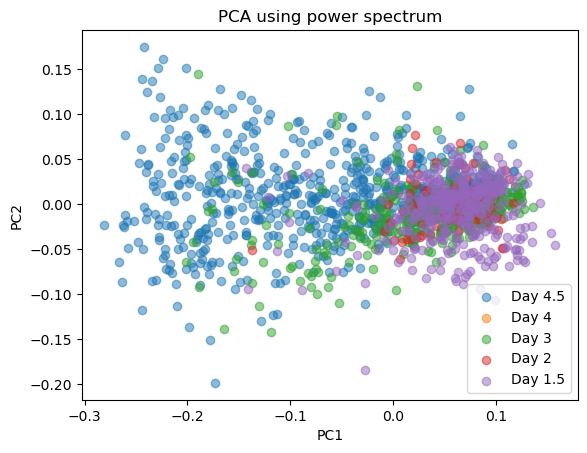

In [ ]:

times_number = np.array(times_number)

for t in [4.5, 3, 2, 1.5]: 
    times_mask = (times_number == t)

    plt.scatter(spectrum_pcs[:, 0][times_mask], spectrum_pcs[:, 1][times_mask], alpha=0.5, label=f'Day {t}')
plt.legend() 
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA using power spectrum')
plt.show()

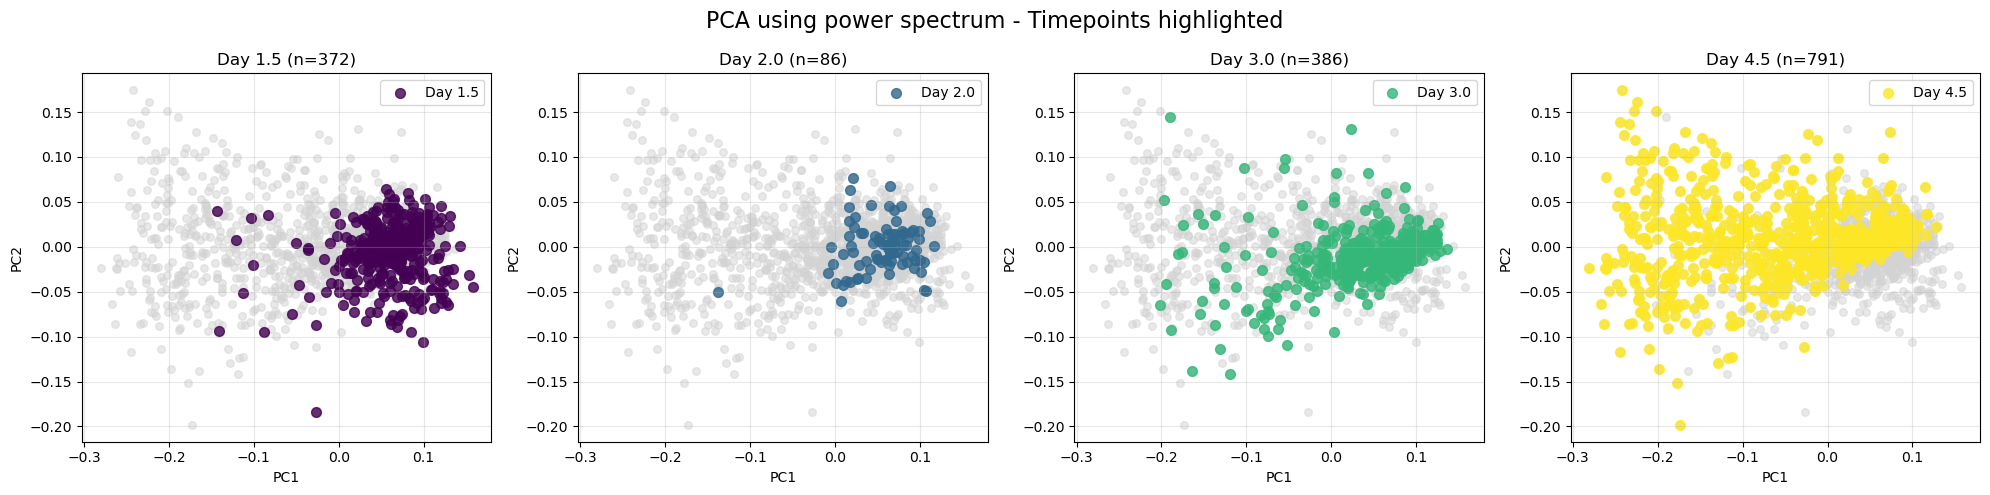

In [196]:
# Create subplots for each timepoint - spectrum PCA
unique_times = np.unique(times_number)
# Use a continuous colormap that represents time progression
cmap = plt.cm.viridis  # You can also try 'plasma', 'inferno', 'magma', 'cool', 'warm'
colors = [cmap(i / (len(unique_times) - 1)) for i in range(len(unique_times))]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, time in enumerate(unique_times):
    ax = axes[i]
    
    # Plot all points in light gray
    ax.scatter(spectrum_pcs[:, 0], spectrum_pcs[:, 1], 
              c='lightgray', alpha=0.5, s=30)
    
    # Highlight current timepoint with color from continuous map
    times_mask = (times_number == time)
    ax.scatter(spectrum_pcs[:, 0][times_mask], spectrum_pcs[:, 1][times_mask], 
              c=[colors[i]], alpha=0.8, s=50, label=f'Day {time}')
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'Day {time} (n={np.sum(times_mask)})')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.suptitle('PCA using power spectrum - Timepoints highlighted', fontsize=16)
plt.tight_layout()
plt.show()

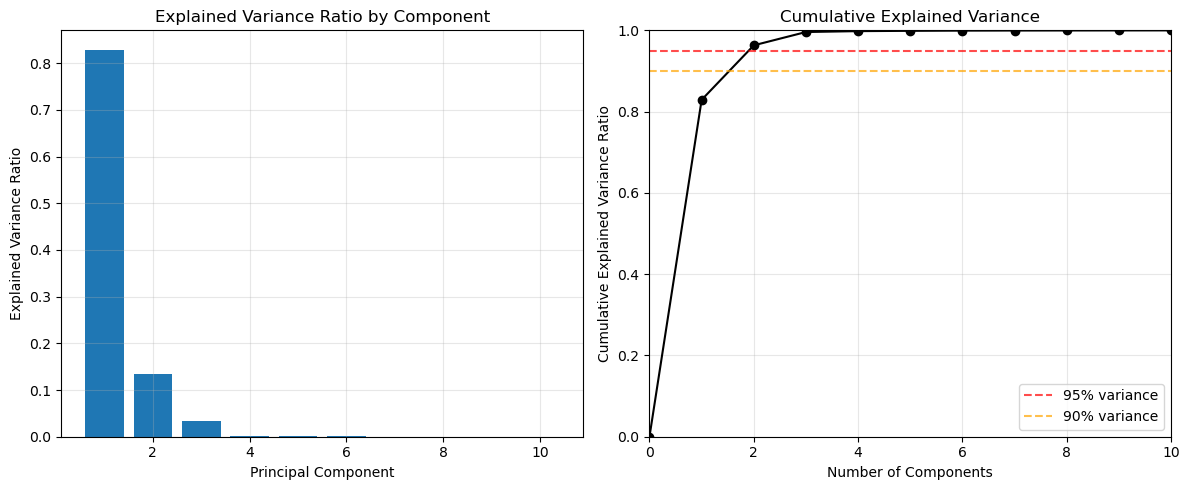

Total explained variance with 10 components: 0.9999
Variance explained by first component: 0.8290
Variance explained by second component: 0.1341


In [173]:
plot_explained_variance(pca)

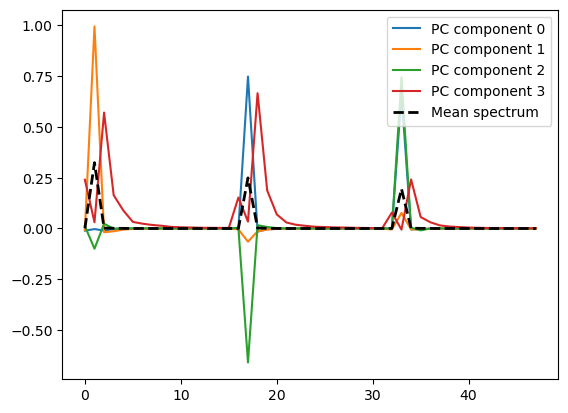

In [174]:
for (i, pc) in enumerate(pca.components_[:4]): 
    plt.plot(pc, '-', label=f'PC component {i}')
plt.plot(pca.mean_, 'k--', label='Mean spectrum', linewidth=2)
plt.legend(loc='upper right') 
plt.show() 

In [136]:
clms_reshaped = np.array(clms).reshape(len(clms), -1)
print(clms_reshaped.shape) 

clms = np.array(clms) 
print(np.array(clms).shape) 
print(clms[0, 0, 0])
print(clms[0, 0, 1])

(1200, 1536)
(1200, 3, 2, 16, 16)
[[-4.88163553e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.20022297e-01  1.25847844e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.74026159e-03  6.92638889e-04  7.33518665e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.06914035e-02 -4.35839303e-03  1.72510715e-02 -1.90395111e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00

In [137]:
pca = PCA(n_components=10)
res = pca.fit(clms_reshaped) 

clm_pcs = pca.transform(clms_reshaped)
print(pca.components_.shape) 

(10, 1536)


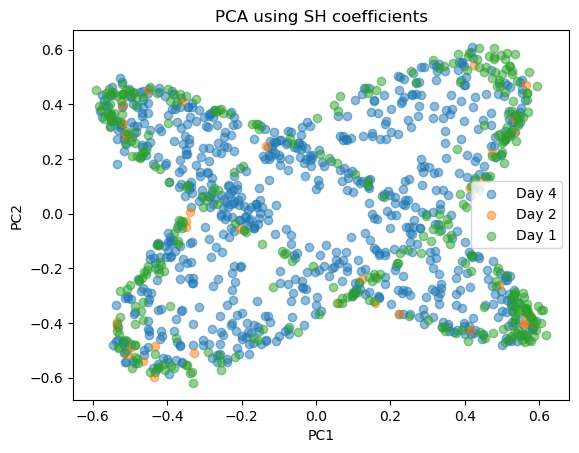

In [141]:

for t in [4, 2, 1]: 
    times_mask = (times[mask] == t)

    plt.scatter(clm_pcs[:, 0][times_mask], clm_pcs[:, 1][times_mask], alpha=0.5, label=f'Day {t}')
plt.legend() 
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA using SH coefficients')
plt.show()

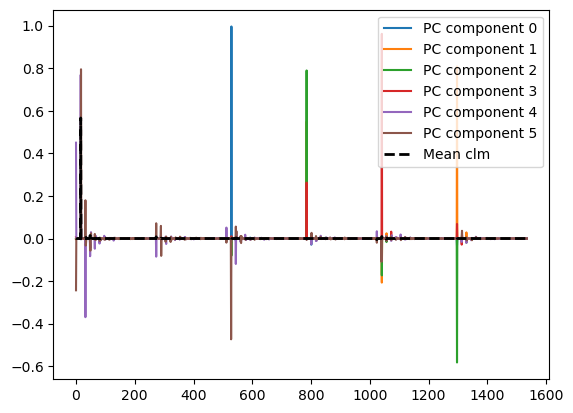

In [142]:
for (i, pc) in enumerate(pca.components_[:6]): 
    plt.plot(pc, '-', label=f'PC component {i}')
plt.plot(pca.mean_, 'k--', label='Mean clm', linewidth=2)
plt.legend(loc='upper right') 
plt.show() 

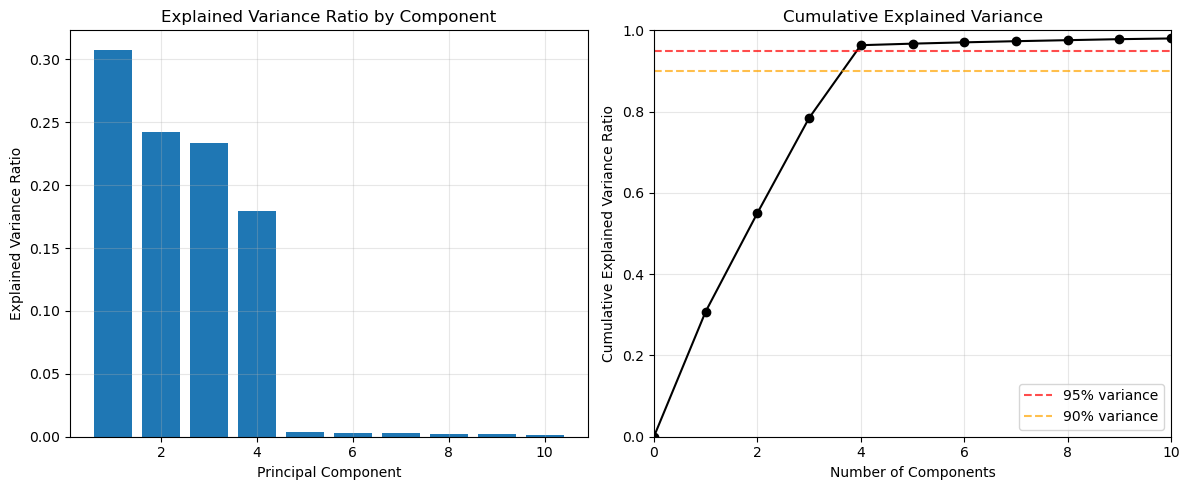

Total explained variance with 10 components: 0.9800
Variance explained by first component: 0.3078
Variance explained by second component: 0.2424


In [143]:
plot_explained_variance(pca)

In [144]:
pca.components_.shape

(10, 1536)

Max value: 0.5661609719796834
Max index: 16
(2, 16, 16)
(2, 16, 16)
(2, 16, 16)


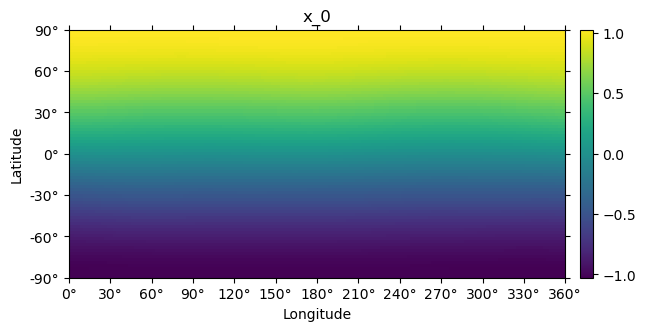

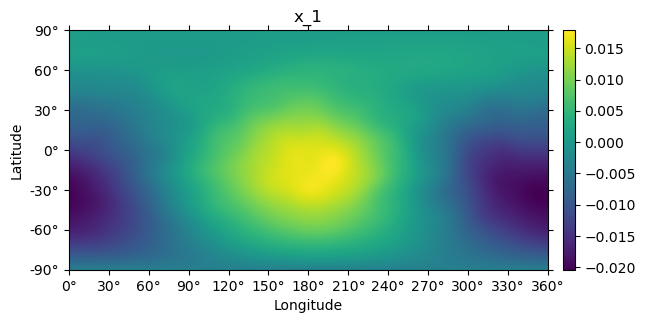

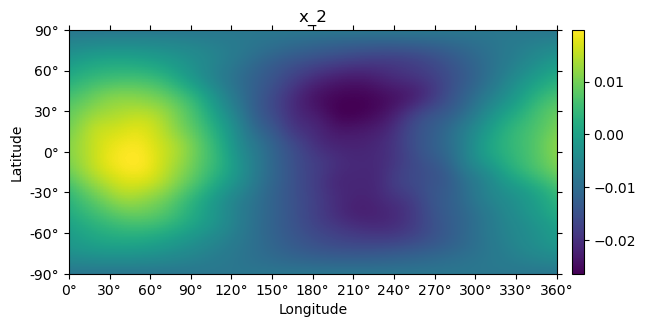

In [145]:
# for (i, pc) in enumerate(pca.components_[:1]):
pc = pca.mean_ 
max_value = np.max(pc)
max_index = np.argmax(pc)
print(f"Max value: {max_value}")
print(f"Max index: {max_index}")

reconstructed_clms = pc.reshape((3, 2, 16, 16))

coors = []
for (i, s) in enumerate(reconstructed_clms): 
    print(s.shape) 
    sh = pysh.SHCoeffs.from_array(s)
    grid = sh.expand(lmax=40)
    coors.append(grid.to_array())

    fig, ax = grid.plot(show=False, colorbar='right')
    ax.set_title(f'x_{i}')

In [146]:
utils.draw_3d_surface(coors[0], coors[1], coors[2], coors[2])